In [1]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
from cryojax.data import RelionParticleParameterDataset, RelionParticleStackDataset
from cryojax.image import irfftn, rfftn
from cryojax.image.operators import LowpassFilter

import cryojax_ensemble_optimization as cxsopt

/mnt/home/dsilvasanchez/virtual_envs/cryojax-er-env/lib/python3.10/site-packages/numpy/_core/getlimits.py:558: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/home/dsilvasanchez/virtual_envs/cryojax-er-env/lib/python3.10/site-packages/numpy/_core/getlimits.py:90: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/home/dsilvasanchez/virtual_envs/cryojax-er-env/lib/python3.10/site-packages/numpy/_core/getlimits.py:558: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/home/dsilvasanchez/virtual_envs/cryojax-er-env/lib/python3.10/site-packages/numpy/_core/getlimits.py:90: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.sm

# Let's load the config file

In [3]:
with open("./config_data_generation.yaml", "r") as f:
    config_json = yaml.safe_load(f)
    config = dict(cxsopt.internal.DatasetGeneratorConfig(**config_json).model_dump())

In [4]:
config

{'number_of_images': 5000,
 'pixel_size': 0.2,
 'box_size': 128,
 'pad_scale': 1,
 'voltage_in_kilovolts': 10.0,
 'offset_x_in_angstroms': Array([0., 0.], dtype=float32),
 'offset_y_in_angstroms': Array([0., 0.], dtype=float32),
 'defocus_in_angstroms': Array([150., 150.], dtype=float32),
 'astigmatism_in_angstroms': Array([0., 0.], dtype=float32),
 'astigmatism_angle_in_degrees': Array([0., 0.], dtype=float32),
 'phase_shift': Array([0., 0.], dtype=float32),
 'amplitude_contrast_ratio': 0.1,
 'spherical_aberration_in_mm': 0.27,
 'ctf_scale_factor': 1.0,
 'envelope_b_factor': Array([0., 0.], dtype=float32),
 'noise_snr': Array([0.1, 0.1], dtype=float32),
 'mask_radius': 60.0,
 'mask_rolloff_width': 1.0,
 'rng_seed': 0,
 'atomic_models_params': {'path_to_atomic_models': ['atomic_models/ala_model_0.pdb',
   'atomic_models/ala_model_1.pdb'],
  'atomic_models_probabilities': Array([0.7, 0.3], dtype=float32),
  'loads_b_factors': True,
  'atom_selection': 'not element H'},
 'path_to_relion_

The image generation can be run from the command line as

`cryojax_er generate_data --config config_data_generation.yaml`

or using jupyter notebook utilities (might fail on some systems):

In [5]:
!cryojax_ensemble_optimization generate_data --config config_data_generation.yaml

/mnt/sw/nix/store/hsdm15phjdgdn220kglhp6lc8sxhnajs-python-3.10.13-view/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


A copy of the config file and the log will be written to tutorial_data


# Visualize the images!

In [6]:
stack_dataset = RelionParticleStackDataset(
    RelionParticleParameterDataset(
        path_to_starfile=config["path_to_starfile"],
        path_to_relion_project=config["path_to_relion_project"],
        loads_envelope=False,
    )
)

In [7]:
lowpass_filter = LowpassFilter(
    stack_dataset[0].parameters.instrument_config.frequency_grid_in_pixels,
    frequency_cutoff_fraction=0.7,
)

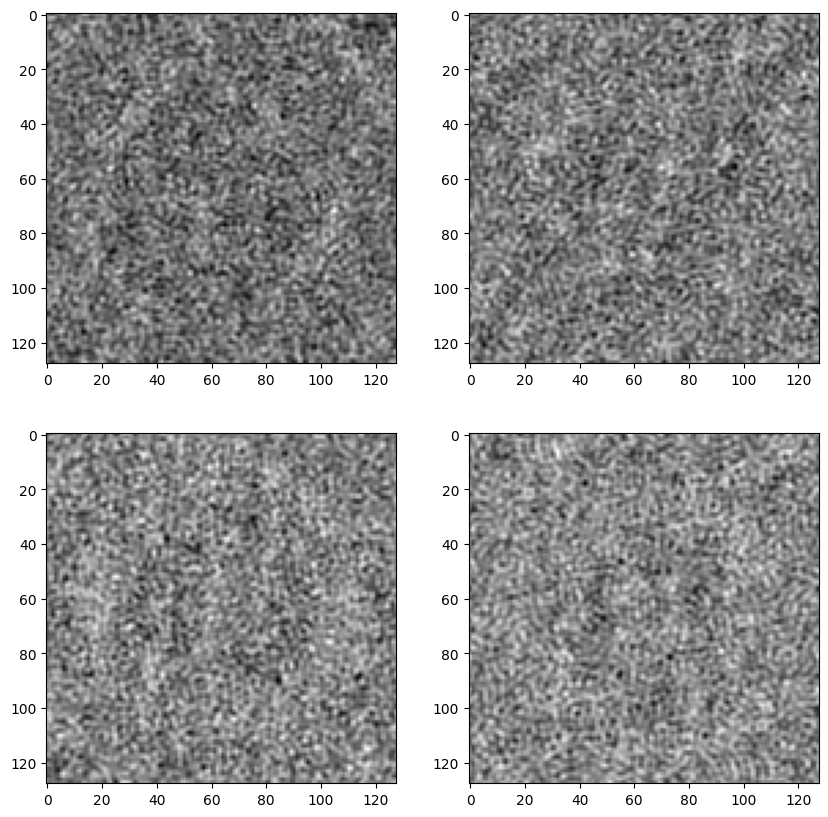

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

images = stack_dataset[0:4].images
images = irfftn(lowpass_filter(rfftn(images)))

for i in range(4):
    ax.flatten()[i].imshow(images[i], cmap="gray")

## Metadata

Information about the ensemble and other parameters is saved to a metadata file

In [9]:
metadata = np.load("tutorial_data/metadata.npz")

metadata.files

['snr_per_image', 'ensemble_indices_per_image']

In [10]:
metadata["ensemble_indices_per_image"]

array([0, 0, 1, ..., 0, 1, 0], shape=(5000,), dtype=int32)

In [11]:
weight_0 = np.isclose(metadata["ensemble_indices_per_image"], 0).mean()
weight_1 = np.isclose(metadata["ensemble_indices_per_image"], 1).mean()

weight_0, weight_1

(np.float64(0.6912), np.float64(0.3088))